<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará el libro La vuelta al mundo en 80 días para generar los embeddings.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizamos como dataset el libro La vuelta al mundo en 80 días, de Julio Verne, como corpus.

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv("/content/La Vuelta al Mundo en 80 Días.txt", sep = '/n', header = None)
df.head()


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,I
1,"En el año 1872, la casa número 7 de Saville-Ro..."
2,"Por consiguiente, Phileas Fogg, personaje enig..."
3,Decíase que se daba un aire a lo Byron —su cab...
4,"Phileas Fogg, era inglés de pura cepa; pero qu..."


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2022


### 1 - Preprocesamiento

Se implementó en el preprocesamiento la función paera quitar acentos y caracteres especiales, números y símbolos de puntuación, ya que el corpus está en español.

In [ ]:
import string
import re
import unicodedata

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    frase = " ".join([str(_) for _ in text_to_word_sequence(row[0])])
    frase = preprocess_clean_text(frase)
    frase = frase.split(' ')
    sentence_tokens.append(frase)

In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['i'],
 ['en',
  'el',
  'ano',
  '',
  'la',
  'casa',
  'numero',
  '',
  'de',
  'saville',
  'row',
  'burlington',
  'gardens',
  'donde',
  'murio',
  'sheridan',
  'en',
  '',
  'estaba',
  'habitada',
  'por',
  'phileas',
  'fogg',
  'quien',
  'a',
  'pesar',
  'de',
  'que',
  'parecia',
  'haber',
  'tomado',
  'el',
  'partido',
  'de',
  'no',
  'hacer',
  'nada',
  'que',
  'pudiese',
  'llamar',
  'la',
  'atencion',
  'era',
  'uno',
  'de',
  'los',
  'miembros',
  'mas',
  'notables',
  'y',
  'singulares',
  'del',
  'reformclub',
  'de',
  'londres']]

### 2 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            EPOCHS.append(0)
            LOSS.append(loss)
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
            EPOCHS.append(self.epoch)
            LOSS.append(loss-self.loss_previous_step)
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectoeres
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=2,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 2022


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 4081


### 3 - Entrenar el modelo generador

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
EPOCHS=[]
LOSS=[] 
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=100,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 798867.0625
Loss after epoch 1: 469075.8125
Loss after epoch 2: 419141.25
Loss after epoch 3: 409420.125
Loss after epoch 4: 350608.5
Loss after epoch 5: 348575.25
Loss after epoch 6: 346738.25
Loss after epoch 7: 344321.0
Loss after epoch 8: 340872.5
Loss after epoch 9: 338856.0
Loss after epoch 10: 318410.25
Loss after epoch 11: 311334.0
Loss after epoch 12: 310526.5
Loss after epoch 13: 303931.5
Loss after epoch 14: 302514.0
Loss after epoch 15: 298656.0
Loss after epoch 16: 293181.5
Loss after epoch 17: 290210.5
Loss after epoch 18: 286074.5
Loss after epoch 19: 282582.0
Loss after epoch 20: 279380.5
Loss after epoch 21: 274086.5
Loss after epoch 22: 271455.5
Loss after epoch 23: 268582.0
Loss after epoch 24: 259338.0
Loss after epoch 25: 248004.0
Loss after epoch 26: 245569.0
Loss after epoch 27: 240866.0
Loss after epoch 28: 238885.0
Loss after epoch 29: 236622.0
Loss after epoch 30: 234864.0
Loss after epoch 31: 232001.0
Loss after epoch 32: 229182.0
Loss aft

(4126994, 6505200)

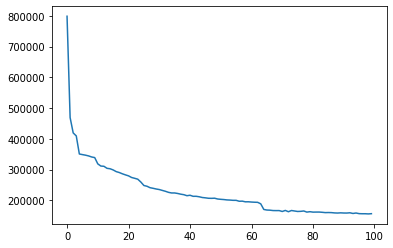

In [ ]:
plt.plot(EPOCHS, LOSS)
plt.show()


### 4 - Ensayar

Para verificar los resultados del entrenamiento, se prueba con los nombres de los protagonistas y de algunos de sus destinos en la historia como palabras de entrada.

In [ ]:
# Palabras que MÁS se relacionan con...:
palabra='phileas'
w2v_model.wv.most_similar(positive=[palabra], topn=10)

[('fogg', 0.5945820808410645),
 ('insistio', 0.42266547679901123),
 ('cualidad', 0.4167048931121826),
 ('leas', 0.41467100381851196),
 ('inmovil', 0.40422677993774414),
 ('dirigiendose', 0.40383368730545044),
 ('partir', 0.39321237802505493),
 ('avisado', 0.3845151960849762),
 ('gentieman', 0.38434547185897827),
 ('lectura', 0.3839886784553528)]

In [ ]:
# Palabras que MENOS se relacionan con...:
palabra='phileas'
w2v_model.wv.most_similar(negative=[palabra], topn=10)

[('hombres', 0.009611077606678009),
 ('nuestra', 0.005752895027399063),
 ('esas', 0.0008283518254756927),
 ('ella', 0.00037241727113723755),
 ('opio', -1.5305355191230774e-05),
 ('uso', -0.00336149288341403),
 ('sometido', -0.004724152386188507),
 ('celeste', -0.00659041665494442),
 ('vaivenes', -0.0069693829864263535),
 ('oriental', -0.008824408054351807)]

Al ingresar el nombre del protagonista, es interesante que la primera palabra con la que lo relaciona es su apellido, además de algunos verbos y adjetivos coherentes con el personaje.

In [ ]:
# Palabras que MÁS se relacionan con...:
palabra='picaporte'
w2v_model.wv.most_similar(positive=[palabra], topn=10)

[('juan', 0.41251808404922485),
 ('ambas', 0.3962543308734894),
 ('reia', 0.3934762477874756),
 ('decian', 0.3700038194656372),
 ('resueltamente', 0.36446771025657654),
 ('altamente', 0.36443832516670227),
 ('contenerse', 0.362531840801239),
 ('maquinalmente', 0.35960596799850464),
 ('ireis', 0.35596078634262085),
 ('oidos', 0.3534070551395416)]

Con el otro protagonista se probó ingresando su apellido y el resultado fue parecido: la palabra con más relación es su nombre.

In [ ]:
# Palabras que MÁS se relacionan con...:
palabra='londres'
w2v_model.wv.most_similar(positive=[palabra], topn=10)

[('turin', 0.5076457262039185),
 ('italianos', 0.4827249050140381),
 ('cenis', 0.4649501442909241),
 ('octubre', 0.45472753047943115),
 ('precipitacion', 0.4531911015510559),
 ('mania', 0.4431685507297516),
 ('nueva', 0.443110853433609),
 ('aplastado', 0.440049409866333),
 ('broadway', 0.438859760761261),
 ('antipodas', 0.43722987174987793)]

Cuando se probó con la palabra "Londres", que es el punto de partida del viaje en el libro, el modelo la relacionó con palabras como "Turín" (ciudad por la que pasan cuando se dirigen a Egipto), "italianos" (directamente relacionada con Turín) y "octubre" (mes en el que comenzaron el viaje).

In [ ]:
# Ensayar con una palabra que no está en el corpus (en vocab):
palabra='verne'
w2v_model.wv.most_similar(negative=[palabra])

KeyError: ignored

Para verificar que el modelo no relaciona palabras que no existen en el corpus, se probó con el apellido del autor y el resultado fue favorable.

### 5 - Visualizar agrupación de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

